# Uncapacitated facility location

Das <code>mip</code>-Paket bzw. die zugrundeliegenden solver vermögen nicht nur lineare Programme zu lösen, sondern auch Ganzzahlprogramme und *mixed integer programmes*. Wir implementieren und lösen hier das Ganzzahlprogramm für uncapacitated facility location:

$$
\begin{array}{lll}
\min & \sum_{i\in\mathcal F}y_if_i
+\sum_{i\in\mathcal F,j\in\mathcal D}x_{ij}c_{ij}, 
& y\in\mathbb R^{\mathcal F},\, x\in\mathbb R^{\mathcal F\times\mathcal D}\\
\textrm{unter} & x_{ij}\leq y_i & \textrm{für alle }i\in\mathcal F,\,j\in\mathcal D\\
& \sum_{i\in\mathcal F}x_{ij}\geq 1 & \textrm{für alle }j\in\mathcal D\\
& x_{ij}\in\{0,1\},\,y_i\in\{0,1\} & \textrm{für alle }i\in\mathcal F,\,j\in\mathcal D
\end{array}
$$


Verwendet wird das <code>mip</code>-Paket. Dokumentation findet sich [hier.](https://python-mip.readthedocs.io/en/latest/)
Wenn Sie in Google Colab arbeiten, dann verwenden Sie die nächste Zelle so wie sie ist. Wenn Sie auf dem eigenen Rechner arbeiten und mip bereits installiert haben, dann löschen Sie die nächste Zelle oder kommentieren Sie per Raute den Installationsbefehl.

In [1]:
# für google colab
!pip install mip  # Löschen / Auskommentieren, wenn Sie mip bereits installiert haben.

Wir brauchen einige Pakete.

In [2]:
import mip  ## Bibliothek für lineare Programme und MIPs
import numpy as np ## Standard-Bibliothek für wiss Rechnen
import random
import math
import matplotlib.pyplot as plt
### Wir benutzen das fivethirtyeight style, damit die plots ein bisschen hübscher aussehen
### könnte auch weggelassen werden
plt.style.use('fivethirtyeight')

## Erzeugung einer Zufallsinstanz

Wie immer brauchen wir eine Beispielsinstanz, die wir zufällig erzeugen. Wir platzieren Standorte und Kunden zufällig in der Ebene. Als Anschluss-/Betriebskosten nehmen wir dann den gewöhnlichen Abstand in der Ebene. Die Konstruktionskosten setzen wir überall auf $1$.

In [3]:
def rnd_instance(num_facilities=10,num_customers=30):
    facilities=[(random.random(),random.random()) for _ in range(num_facilities)]
    customers=[(random.random(),random.random()) for _ in range(num_customers)]
    opening_costs=[1]*num_facilities  ## for simplicity, all opening costs are 1
    return facilities,customers,opening_costs

def distance(facility,customer):
    px,py=facility
    qx,qy=customer
    return math.sqrt((px-qx)**2+(py-qy)**2)

facilities,customers,opening_costs=rnd_instance()

Ein bisschen Visualisierungscode. Der ist ein wenig komplizierter, aber nicht notwendig, um das MIP bzw dessen Lösung zu verstehen. Dh, einfach ignorieren. 

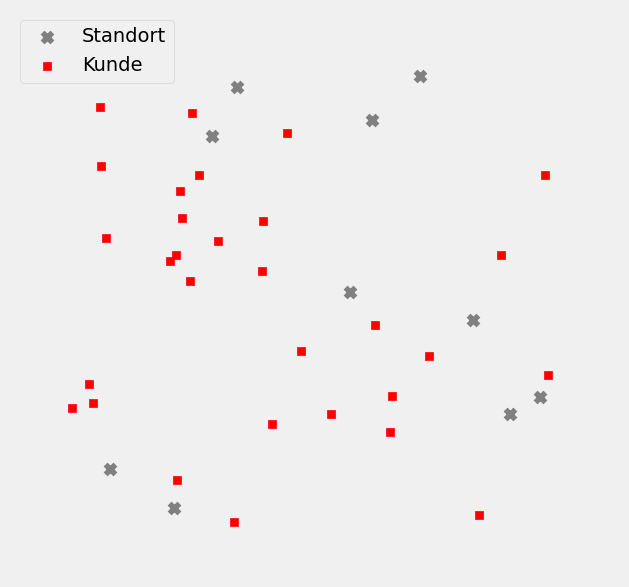

In [4]:
def show(facilities,customers,x=None,y=None):
    plt.figure(figsize=(7,7))
    BB=np.array(facilities)
    CC=np.array(customers)
    if y is None:
        closed=BB
    else:
        opened=np.array([F for i,F in enumerate(facilities) if y[i].x==1])
        closed=np.array([F for i,F in enumerate(facilities) if y[i].x==0])
        plt.scatter(opened[:,0],opened[:,1],color='blue',s=100,marker='o',label="offen")
    plt.scatter(closed[:,0],closed[:,1],color='gray',s=50,marker='x',label="Standort")
    plt.scatter(CC[:,0],CC[:,1],color='red',marker='s',label="Kunde")
    if x is not None:
        for i in range(len(facilities)):
            for j in range(len(customers)):
                if x[i][j].x>0.0001:
                    plt.plot([BB[i,0],CC[j,0]],[BB[i,1],CC[j,1]],'k',zorder=-1,alpha=0.5,linewidth=2)
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.xticks([])
    plt.yticks([])
    plt.legend(loc="upper left")
    plt.show()   

show(facilities,customers)

## Das MIP

Wir starten damit, das <code>Model</code> zu instantiieren. 

In [5]:
model=mip.Model()
num_customers=len(customers)
num_facilities=len(facilities)

Binäre Variablen werden erzeugt, in dem <code>var_type=mip.BINARY</code> gesetzt wird. Für ganzzahlige Variablen würde man hier <code>var_type=mip.INTEGER</code> setzen.

$y_i\in\{0,1\}$

In [6]:
y=[model.add_var(var_type=mip.BINARY) for _ in range(num_facilities)]

Als nächstes erzeugen wir die Anschlussvariablen.

$x_{ij}\in\{0,1\}$

In [7]:
x=[[model.add_var(var_type=mip.BINARY) for _ in range(num_customers)] for _ in range(num_facilities)]

Die Zielfunktion. Als Anschluss-/Betriebkosten nehmen wir den Abstand in der Ebene.

$\min\sum_{i}y_if_i+\sum_{ij}x_{ij}c_{ij}$

In [8]:
model.objective=mip.minimize(mip.xsum(y[i]*opening_costs[i] for i in range(num_facilities)) + \
                         mip.xsum(x[i][j]*distance(facilities[i],customers[j]) for i in range(num_facilities) for j in range(num_customers)))

Was macht der Backslash <code>\\</code> da am Ende der ersten Zeile? Python Python definiert Codeblöcke durch Einrückungen und erwartet pro Zeile einen Befehl. Manchmal, wie hier die Zielfunktion, ist ein Befehl aber sehr lang & aus Gründen der Übersichtlichkeit möchte man den Befehl gerne auf mehrere Zeilen aufteilen. Der Backslash am Ende der Zeile signalisiert Python, dass der Befehl in der nächsten Zeile fortgesetzt wird. Dies ist auch über mehrere Zeilen möglich.

und reagiert daher ein wenig ungehalten, wenn man eine zu lange Zeile einfach unterbricht und in der nächsten Zeile fortsetzt. 

Die Indikatorvariablebedingungen -- kein Anschluss zu einer nicht geöffneten facility:

$x_{ij}\leq y_i$

In [9]:
for i in range(num_facilities):
    for j in range(num_customers):
        model+=x[i][j]<=y[i]

Jeder Kunde muss angeschlossen werden:

$\sum_{i}x_{ij}\geq 1$ 

In [10]:
for j in range(num_customers):
    model+=mip.xsum(x[i][j] for i in range(num_facilities)) >= 1

Wir starten die Optimierung und lassen uns gleich die Lösung anzeigen:

Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 330 (0) rows, 310 (0) columns and 900 (0) elements
Clp1000I sum of infeasibilities 3.12244e-07 - average 9.46193e-10, 130 fixed columns
Coin0506I Presolve 200 (-130) rows, 180 (-130) columns and 510 (-390) elements
Clp0029I End of values pass after 180 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000005 - largest nonzero change 2.9031261e-05 ( 0.001451563%) - largest zero change 2.9522154e-05
Clp0000I Optimal - objective value 9.7622838
Clp0000I Optimal - objective value 9.7622838
Coin0511I After Postsolve, objective 9.7622838, infeasibilities - dual 0 (0), primal 0 (0)
Clp0000I Optimal - objective value 9.7622838
Clp0000I Optimal - objective value 9.7622838
Clp0000I Optimal - objective value 9.7622838
Clp0032I Optimal objective 9.76228376 - 0 iterations time 0.022, Idiot 0.02

Starting MIP optimizatio

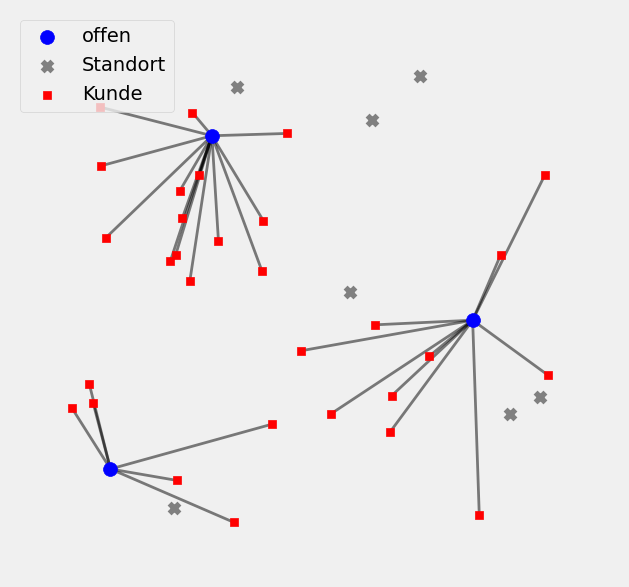

In [11]:
model.optimize()

show(facilities,customers,x,y)